<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Exploration-Data" data-toc-modified-id="Exploration-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Exploration Data</a></span></li><li><span><a href="#Modeling-Data" data-toc-modified-id="Modeling-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Modeling Data</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Full-Data-Visualization" data-toc-modified-id="Full-Data-Visualization-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Full Data Visualization</a></span></li><li><span><a href="#Modeling-Data-Preparation" data-toc-modified-id="Modeling-Data-Preparation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Modeling Data Preparation</a></span></li></ul></li><li><span><a href="#Standard-Models" data-toc-modified-id="Standard-Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standard Models</a></span><ul class="toc-item"><li><span><a href="#Two-Model" data-toc-modified-id="Two-Model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Two Model</a></span></li><li><span><a href="#Interaction-Term" data-toc-modified-id="Interaction-Term-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Interaction Term</a></span></li><li><span><a href="#Class-Transformations" data-toc-modified-id="Class-Transformations-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Class Transformations</a></span><ul class="toc-item"><li><span><a href="#Binary-Transformation" data-toc-modified-id="Binary-Transformation-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Binary Transformation</a></span></li><li><span><a href="#Quaternary-Transformation" data-toc-modified-id="Quaternary-Transformation-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Quaternary Transformation</a></span></li></ul></li><li><span><a href="#Reflective-Uplift" data-toc-modified-id="Reflective-Uplift-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Reflective Uplift</a></span></li><li><span><a href="#Pessimistic-Uplift" data-toc-modified-id="Pessimistic-Uplift-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Pessimistic Uplift</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Iterations" data-toc-modified-id="Iterations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Iterations</a></span></li><li><span><a href="#Visual" data-toc-modified-id="Visual-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visual</a></span></li><li><span><a href="#Iterated-Evaluation-and-Variance" data-toc-modified-id="Iterated-Evaluation-and-Variance-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Iterated Evaluation and Variance</a></span></li></ul></li></ul></div>

**Mayo PBC Dataset**

A dataset on medical trials to combat primary biliary cholangitis (PBC, formerly cirrhosis) of the liver from the Mayo Clinic.

If using this notebook in [Google Colab](https://colab.research.google.com/github/andrewtavis/causeinfer/blob/main/examples/medical_mayo_pbc.ipynb), you can activate GPUs by following `Edit > Notebook settings > Hardware accelerator` and selecting `GPU`.

In [1]:
# pip install causeinfer -U

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from causeinfer import utils
from causeinfer.data import mayo_pbc
from causeinfer.evaluation import (
    auuc_score,
    eval_table,
    iterate_model,
    plot_batch_responses,
    plot_cum_effect,
    plot_cum_gain,
    plot_qini,
    qini_score,
    signal_to_noise,
)
from causeinfer.standard_algorithms.binary_transformation import BinaryTransformation
from causeinfer.standard_algorithms.interaction_term import InteractionTerm
from causeinfer.standard_algorithms.pessimistic import PessimisticUplift
from causeinfer.standard_algorithms.quaternary_transformation import (
    QuaternaryTransformation,
)
from causeinfer.standard_algorithms.reflective import ReflectiveUplift
from causeinfer.standard_algorithms.two_model import TwoModel

pd.set_option("display.max_rows", 16)
pd.set_option("display.max_columns", None)

from IPython.core.display import HTML, display

display(HTML("<style>.container { width:99% !important; }</style>"))

# Load Data

In [2]:
mayo_pbc.download_mayo_pbc()

The dataset already exists at /Users/andrewtavis/Documents/learning/coding/causeinfer/examples/datasets/mayo_pbc.text


## Exploration Data

In [3]:
# The full mostly unformatted dataset is loaded
data_raw = mayo_pbc.load_mayo_pbc(
    file_path="datasets/mayo_pbc.text", format_covariates=False, normalize=False
)

df_full = pd.DataFrame(data_raw["dataset_full"], columns=data_raw["dataset_full_names"])

display(df_full.head())
df_full.shape

,treatment,days_since_register,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alkaline,sgot,triglicerides,platelets,prothrombin,status,histologic_stage
0,1.0,400.0,21464.0,1.0,1.0,1.0,1.0,1.0,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,2.0,4.0
1,1.0,4500.0,20617.0,1.0,0.0,1.0,1.0,0.0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,0.0,3.0
2,1.0,1012.0,25594.0,0.0,0.0,0.0,0.0,0.5,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,2.0,4.0
3,1.0,1925.0,19994.0,1.0,0.0,1.0,1.0,0.5,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,2.0,4.0
4,0.0,1504.0,13918.0,1.0,0.0,1.0,1.0,0.0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,1.0,3.0


(312, 19)

## Modeling Data

In [4]:
# The formatted dataset is loaded
data_mayo_pbc = mayo_pbc.load_mayo_pbc(
    file_path="datasets/mayo_pbc.text", format_covariates=True, normalize=True
)

df = pd.DataFrame(
    data_mayo_pbc["dataset_full"], columns=data_mayo_pbc["dataset_full_names"]
)
display(df.head())
df.shape

,treatment,days_since_register,age,sex,ascites,hepatomegaly,spiders,bilirubin,cholesterol,albumin,copper,alkaline,sgot,triglicerides,platelets,prothrombin,no_edema_no_diuretics,yes_edema_no_diuretics,yes_edema_yes_diuretics,histologic_stage_1,histologic_stage_2,histologic_stage_3,status,histologic_stage_4
0,1.0,-1.430063,0.826577,1.0,1.0,1.0,1.0,2.481927,-0.490428,-2.191039,0.683769,-0.123648,0.271495,0.763771,-0.757276,1.468012,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0
1,1.0,2.219959,0.607419,1.0,0.0,1.0,1.0,-0.475925,-0.305123,1.476570,-0.511475,2.528580,-0.159373,-0.592670,-0.430932,-0.125100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,-0.885230,1.895194,0.0,0.0,0.0,0.0,-0.409704,-0.874596,-0.095263,1.316546,-0.685229,-0.466606,-1.125558,-1.167837,1.268873,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
3,1.0,-0.072433,0.446221,1.0,0.0,1.0,1.0,-0.321410,-0.567261,-2.333933,-0.394295,1.933828,-1.092185,-0.528078,-0.830966,-0.423809,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
4,0.0,-0.447228,-1.125915,1.0,0.0,1.0,1.0,0.031766,-0.409074,0.023816,0.531434,-0.612812,-0.165898,-0.851040,-1.325745,0.173608,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


(312, 24)

In [5]:
# Covariates, treatments and responses are loaded separately
X = data_mayo_pbc["features"]

# 0 is the patient is alive, 1 is a liver transplant, 2 is deceased
y = data_mayo_pbc["response"]

w = data_mayo_pbc["treatment"]

# Data Exploration

In [6]:
sns.set(style="whitegrid")

## Full Data Visualization

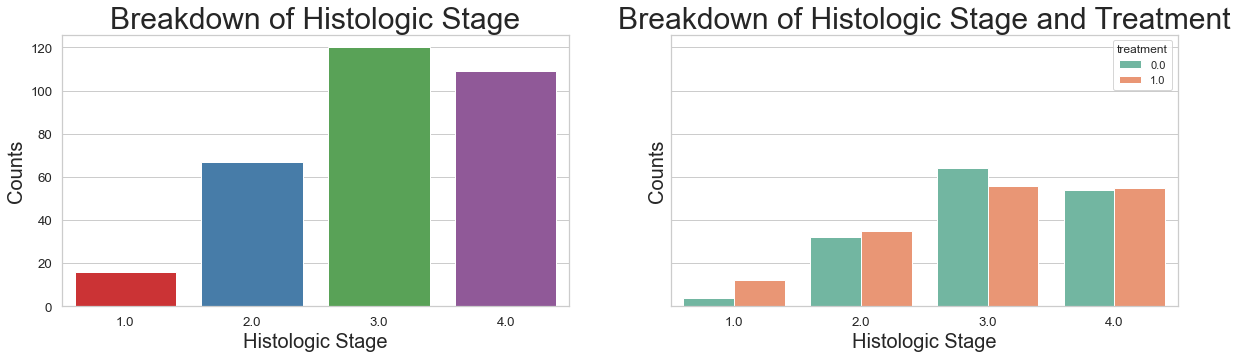

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
fontsize = 20

(
    utils.plot_unit_distributions(
        df=df_full,
        variable="histologic_stage",
        treatment=None,
        bins=None,
        axis=ax1,
    ),
)

ax1.set_xlabel("Histologic Stage", fontsize=fontsize)
ax1.set_ylabel("Counts", fontsize=fontsize)
ax1.axes.set_title("Breakdown of Histologic Stage", fontsize=fontsize * 1.5)
ax1.tick_params(labelsize=fontsize / 1.5)
ax1.set_xticklabels(ax1.get_xticklabels())

utils.plot_unit_distributions(
    df=df_full,
    variable="histologic_stage",
    treatment="treatment",
    bins=None,
    axis=ax2,
)

ax2.set_xlabel("Histologic Stage", fontsize=fontsize)
ax2.set_ylabel("Counts", fontsize=fontsize)
ax2.axes.set_title(
    "Breakdown of Histologic Stage and Treatment", fontsize=fontsize * 1.5
)
ax2.tick_params(labelsize=fontsize / 1.5)
ax2.set_xticklabels(ax2.get_xticklabels())

# plt.savefig('outputs_images/mayo_breakdown_histologic_stage.png', dpi=150)
plt.show()

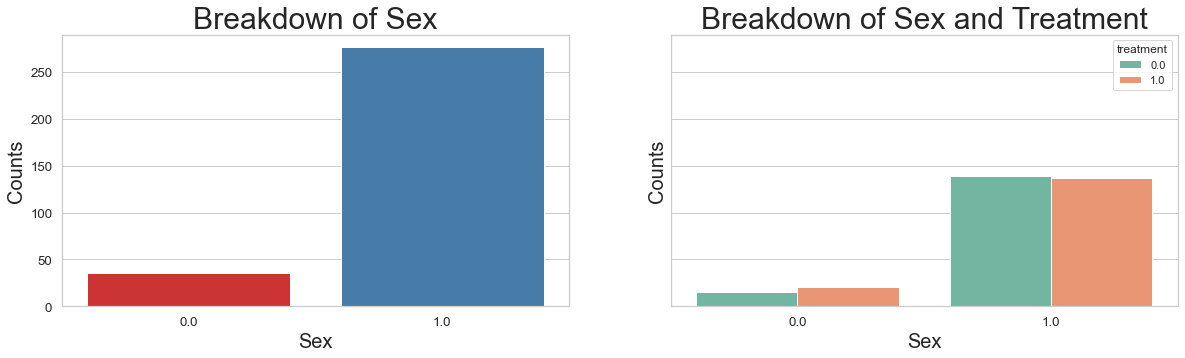

In [8]:
# 0=male, 1=female
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
fontsize = 20

(
    utils.plot_unit_distributions(
        df=df_full,
        variable="sex",
        treatment=None,
        bins=None,
        axis=ax1,
    ),
)

ax1.set_xlabel("Sex", fontsize=fontsize)
ax1.set_ylabel("Counts", fontsize=fontsize)
ax1.axes.set_title("Breakdown of Sex", fontsize=fontsize * 1.5)
ax1.tick_params(labelsize=fontsize / 1.5)
ax1.set_xticklabels(ax1.get_xticklabels())

utils.plot_unit_distributions(
    df=df_full,
    variable="sex",
    treatment="treatment",
    bins=None,
    axis=ax2,
)

ax2.set_xlabel("Sex", fontsize=fontsize)
ax2.set_ylabel("Counts", fontsize=fontsize)
ax2.axes.set_title("Breakdown of Sex and Treatment", fontsize=fontsize * 1.5)
ax2.tick_params(labelsize=fontsize / 1.5)
ax2.set_xticklabels(ax2.get_xticklabels())

# plt.savefig('outputs_images/mayo_breakdown_sex.png', dpi=150)
plt.show()

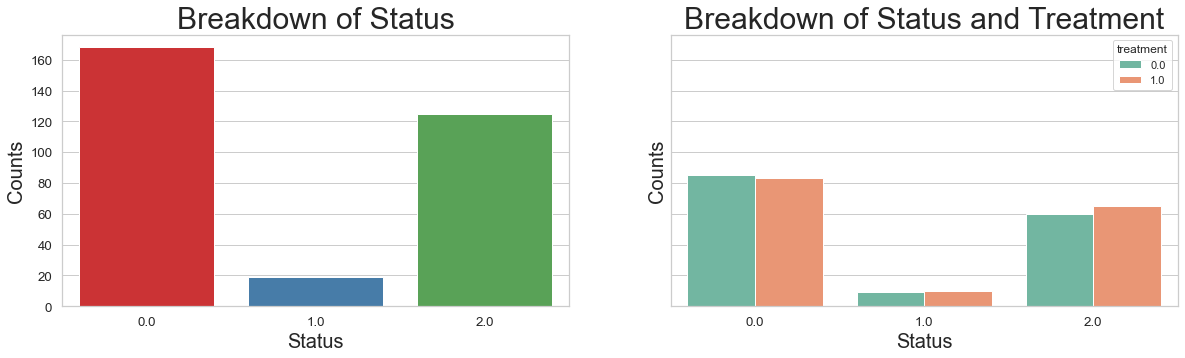

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
fontsize = 20

(
    utils.plot_unit_distributions(
        df=df_full,
        variable="status",
        treatment=None,
        bins=None,
        axis=ax1,
    ),
)

ax1.set_xlabel("Status", fontsize=fontsize)
ax1.set_ylabel("Counts", fontsize=fontsize)
ax1.axes.set_title("Breakdown of Status", fontsize=fontsize * 1.5)
ax1.tick_params(labelsize=fontsize / 1.5)
ax1.set_xticklabels(ax1.get_xticklabels())

utils.plot_unit_distributions(
    df=df_full,
    variable="status",
    treatment="treatment",
    bins=None,
    axis=ax2,
)

ax2.set_xlabel("Status", fontsize=fontsize)
ax2.set_ylabel("Counts", fontsize=fontsize)
ax2.axes.set_title("Breakdown of Status and Treatment", fontsize=fontsize * 1.5)
ax2.tick_params(labelsize=fontsize / 1.5)
ax2.set_xticklabels(ax2.get_xticklabels())

# plt.savefig('outputs_images/mayo_breakdown_status.png', dpi=150)
plt.show()

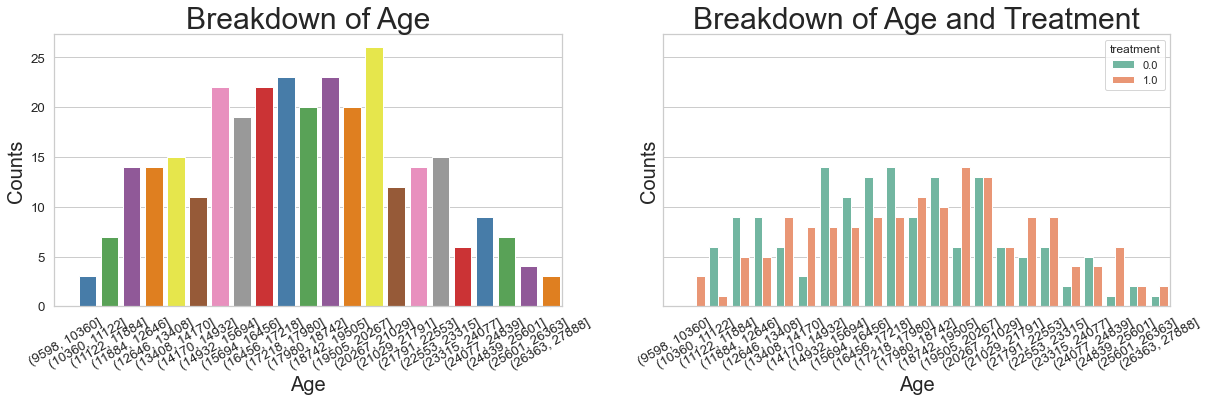

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 5))
fontsize = 20

(
    utils.plot_unit_distributions(
        df=df_full,
        variable="age",
        treatment=None,
        bins=25,
        axis=ax1,
    ),
)

ax1.set_xlabel("Age", fontsize=fontsize)
ax1.set_ylabel("Counts", fontsize=fontsize)
ax1.axes.set_title("Breakdown of Age", fontsize=fontsize * 1.5)
ax1.tick_params(labelsize=fontsize / 1.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)

utils.plot_unit_distributions(
    df=df_full,
    variable="age",
    treatment="treatment",
    bins=25,
    axis=ax2,
)

ax2.set_xlabel("Age", fontsize=fontsize)
ax2.set_ylabel("Counts", fontsize=fontsize)
ax2.axes.set_title("Breakdown of Age and Treatment", fontsize=fontsize * 1.5)
ax2.tick_params(labelsize=fontsize / 1.5)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

# plt.savefig('outputs_images/mayo_breakdown_age.png', dpi=150)
plt.show()

In [11]:
pd.crosstab(df["treatment"], df["status"], margins=True, normalize=True)

status,0.0,1.0,2.0,All
treatment,,,,
0.0,0.272436,0.028846,0.192308,0.49359
1.0,0.266026,0.032051,0.208333,0.50641
All,0.538462,0.060897,0.400641,1.00000


In [12]:
df["alive"] = [1 if i == 0 else 0 for i in df["status"]]
df["transplant"] = [1 if i == 1 else 0 for i in df["status"]]
df["deceased"] = [1 if i == 2 else 0 for i in df["status"]]

In [13]:
df.pivot_table(
    values=["alive", "transplant", "deceased"],
    index="treatment",
    aggfunc=[np.mean],
    margins=True,
)

mean                     
              alive  deceased transplant
treatment                               
0.0        0.551948  0.389610   0.058442
1.0        0.525316  0.411392   0.063291
All        0.538462  0.400641   0.060897

## Modeling Data Preparation

In [14]:
# Counts for response
alive_indexes = [i for i, e in enumerate(y) if e == 0]
transplant_indexes = [i for i, e in enumerate(y) if e == 1]
deceased_indexes = [i for i, e in enumerate(y) if e == 2]

transplant_deceased_indexes = transplant_indexes + deceased_indexes

print(len(alive_indexes))
print(len(transplant_indexes))
print(len(deceased_indexes))
print(len(transplant_deceased_indexes))

168
19
125
144


In [15]:
y = np.array([1 if i in transplant_deceased_indexes else 0 for i, e in enumerate(y)])

In [16]:
# Counts for treatment
control_indexes = [i for i, e in enumerate(w) if e == 0]
treatment_indexes = [i for i, e in enumerate(w) if e == 1]

print(len(control_indexes))
print(len(treatment_indexes))

154
158


In [17]:
X_control = X[control_indexes]
y_control = y[control_indexes]
w_control = w[control_indexes]

X_treatment = X[treatment_indexes]
y_treatment = y[treatment_indexes]
w_treatment = w[treatment_indexes]

In [18]:
# Over-sampling of control
X_os, y_os, w_os = utils.over_sample(
    X_1=X_control,
    y_1=y_control,
    w_1=w_control,
    sample_2_size=len(X_treatment),
    shuffle=True,
)


    Old Covariates shape  : (154, 22)
    Old responses shape   : (154,)
    Old treatments shape  : (154,)
    New covariates shape  : (158, 22)
    New responses shape   : (158,)
    New treatments shape  : (158,)
    Matched sample length :  158
                        


In [19]:
X_split = np.append(X_os, X_treatment, axis=0)
y_split = np.append(y_os, y_treatment, axis=0)
w_split = np.append(w_os, w_treatment, axis=0)

(
    X_split.shape,
    y_split.shape,
    w_split.shape,
)  # Should all be equal in the first dimension

((316, 22), (316,), (316,))

In [20]:
X_train, X_test, y_train, y_test, w_train, w_test = utils.train_test_split(
    X_split,
    y_split,
    w_split,
    percent_train=0.7,
    random_state=42,
    maintain_proportions=True,
)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, w_train.shape, w_test.shape

((220, 22), (96, 22), (220,), (96,), (220,), (96,))

In [22]:
print(np.array(np.unique(y_train, return_counts=True)).T)
print(np.array(np.unique(y_test, return_counts=True)).T)

[[  0 120]
 [  1 100]]
[[ 0 52]
 [ 1 44]]


In [23]:
print(np.array(np.unique(w_train, return_counts=True)).T)
print(np.array(np.unique(w_test, return_counts=True)).T)

[[  0. 110.]
 [  1. 110.]]
[[ 0. 48.]
 [ 1. 48.]]


In [24]:
sn_ratio = signal_to_noise(y=y_split, w=w_split)
sn_ratio

0.08695652173913043

The signal to noise ratio suggests at a base level that there may be little use for CI with this dataset.

# Standard Models

The following cells present single iteration modeling, with analysis being done over multiple iterations.

## Two Model

In [25]:
tm = TwoModel(
    treatment_model=RandomForestClassifier(), control_model=RandomForestClassifier()
)
tm.fit(X=X_train, y=y_train, w=w_train)

In [26]:
tm_probas = tm.predict_proba(X=X_test)
tm_probas[:5]

array([[0.86, 0.83],
       [0.43, 0.73],
       [0.7 , 0.74],
       [0.37, 0.48],
       [0.79, 0.66]])

## Interaction Term

In [27]:
it = InteractionTerm(model=RandomForestClassifier())
it.fit(X=X_train, y=y_train, w=w_train)

In [28]:
it_probas = it.predict_proba(X=X_test)
it_probas[:5]

array([[0.87, 0.87],
       [0.41, 0.54],
       [0.8 , 0.79],
       [0.34, 0.38],
       [0.83, 0.72]])

## Class Transformations

### Binary Transformation

In [29]:
bt = BinaryTransformation(model=RandomForestClassifier(), regularize=False)
bt.fit(X=X_train, y=y_train, w=w_train)

In [30]:
bt_probas = bt.predict_proba(X=X_test)
bt_probas[:5]

array([[0.4 , 0.6 ],
       [0.55, 0.45],
       [0.57, 0.43],
       [0.59, 0.41],
       [0.46, 0.54]])

### Quaternary Transformation

In [31]:
qt = QuaternaryTransformation(model=RandomForestClassifier(), regularize=False)
qt.fit(X=X_train, y=y_train, w=w_train)

In [32]:
qt_probas = qt.predict_proba(X=X_test)
qt_probas[:5]

array([[0.33, 0.67],
       [0.67, 0.33],
       [0.59, 0.41],
       [0.56, 0.44],
       [0.37, 0.63]])

## Reflective Uplift

In [33]:
ru = ReflectiveUplift(model=RandomForestClassifier())
ru.fit(X=X_train, y=y_train, w=w_train)

In [34]:
ru_probas = ru.predict_proba(X=X_test)
ru_probas[:5]

array([[0.0791 , 0.40125],
       [0.2482 , 0.2508 ],
       [0.13195, 0.35505],
       [0.2904 , 0.21295],
       [0.14765, 0.3401 ]])

## Pessimistic Uplift

In [35]:
pu = PessimisticUplift(model=RandomForestClassifier())
pu.fit(X=X_train, y=y_train, w=w_train)

In [36]:
pu_probas = pu.predict_proba(X=X_test)
pu_probas[:5]

array([[0.0948  , 0.2307  ],
       [0.2015  , 0.277675],
       [0.1412  , 0.2377  ],
       [0.34405 , 0.240475],
       [0.186625, 0.213   ]])

# Evaluation

## Iterations

In [37]:
# New models instatiated with a more expansive scikit-learn base model (assign individually)
tm = TwoModel(
    treatment_model=RandomForestClassifier(
        n_estimators=200, criterion="gini", bootstrap=True
    ),
    control_model=RandomForestClassifier(
        n_estimators=200, criterion="gini", bootstrap=True
    ),
)

it = InteractionTerm(
    model=RandomForestClassifier(n_estimators=200, criterion="gini", bootstrap=True)
)

bt = BinaryTransformation(
    model=RandomForestClassifier(n_estimators=200, criterion="gini", bootstrap=True),
    regularize=False,
)

qt = QuaternaryTransformation(
    model=RandomForestClassifier(n_estimators=200, criterion="gini", bootstrap=True),
    regularize=False,
)

ru = ReflectiveUplift(
    model=RandomForestClassifier(n_estimators=200, criterion="gini", bootstrap=True)
)

pu = PessimisticUplift(
    model=RandomForestClassifier(n_estimators=200, criterion="gini", bootstrap=True)
)

In [38]:
n = 200
model_eval_dict = {}
model_eval_dict["Mayo PBC"] = {}
model_eval_dict

{'Mayo PBC': {}}

In [39]:
for dataset in model_eval_dict.keys():
    for model in [tm, it, bt, qt, ru, pu]:
        (
            avg_preds,
            all_preds,
            avg_eval,
            eval_variance,
            eval_sd,
            all_evals,
        ) = iterate_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            w_train=w_train,
            X_test=X_test,
            y_test=y_test,
            w_test=w_test,
            tau_test=None,
            n=n,
            pred_type="predict_proba",
            eval_type="qini",
            normalize_eval=False,
            verbose=False,  # Progress bar
        )
        model_eval_dict[dataset].update(
            {
                str(model).split(".")[-1].split(" ")[0]: {
                    "avg_preds": avg_preds,
                    "all_preds": all_preds,
                    "avg_eval": avg_eval,
                    "eval_variance": eval_variance,
                    "eval_sd": eval_sd,
                    "all_evals": all_evals,
                }
            }
        )

In [40]:
# Treatment and control probability subtraction
tm_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["TwoModel"]["avg_preds"]
]

# Treatment interaction and control interaction probability subtraction
it_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["InteractionTerm"]["avg_preds"]
]

# Binary favorable and unfavorable class probability subtraction
bt_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["BinaryTransformation"]["avg_preds"]
]

# Quaternary favorable and unfavorable class probability subtraction
qt_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["QuaternaryTransformation"]["avg_preds"]
]

# Reflective favorable and unfavorable class probability subtraction
ru_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["ReflectiveUplift"]["avg_preds"]
]

# Pessimistic favorable and unfavorable class probability subtraction
pu_effects = [
    proba[0] - proba[1]
    for proba in model_eval_dict["Mayo PBC"]["PessimisticUplift"]["avg_preds"]
]

## Visual

In [41]:
visual_eval_dict = {
    "y_test": y_test,
    "w_test": w_test,
    "two_model": tm_effects,
    "interaction_term": it_effects,
    "binary_trans": bt_effects,
    "quaternary_trans": qt_effects,
    "reflective": ru_effects,
    "pessimistic": pu_effects,
}

In [42]:
df_visual_eval = pd.DataFrame(visual_eval_dict, columns=visual_eval_dict.keys())

display(df_visual_eval.head())
df_visual_eval.shape

,y_test,w_test,two_model,interaction_term,binary_trans,quaternary_trans,reflective,pessimistic
0,0,1.0,0.103875,0.044275,-0.25720,-0.22280,-0.323064,-0.159040
1,0,0.0,-0.297900,-0.183875,0.13465,0.23145,-0.001147,-0.071485
2,1,0.0,-0.038500,-0.036775,0.22705,0.21980,-0.207335,-0.112892
3,1,1.0,-0.065825,-0.045525,0.12070,0.12740,0.127575,0.062856
4,0,1.0,0.165900,0.057850,-0.15410,-0.09760,-0.180335,-0.029669


(96, 8)

In [43]:
models = [col for col in visual_eval_dict.keys() if col not in ["y_test", "w_test"]]

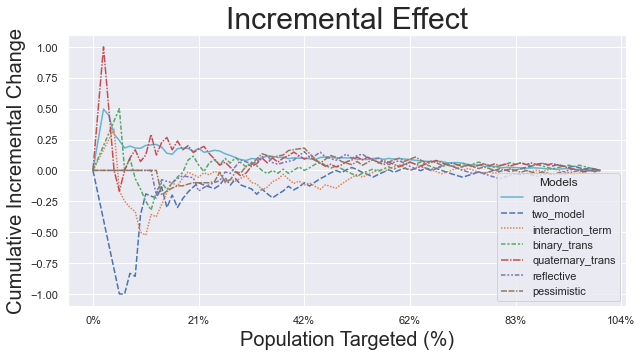

In [44]:
# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(20,5))

plot_cum_effect(
    df=df_visual_eval,
    n=100,
    models=models,
    percent_of_pop=True,
    outcome_col="y_test",
    treatment_col="w_test",
    random_seed=42,
    figsize=(10, 5),
    fontsize=20,
    axis=None,
    legend_metrics=False,
)

# plot_batch_responses(df=df_visual_eval, n=10, models=models,
#                      outcome_col='y_test', treatment_col='w_test', normalize=False,
#                      figsize=None, fontsize=15, axis=ax2)
plt.savefig("./mayo_cum_effect.png", dpi=150)

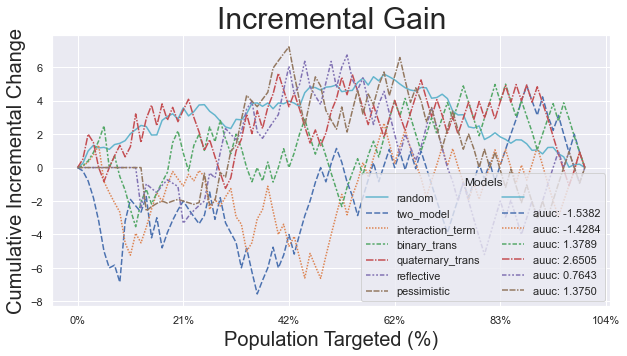

In [45]:
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(20, 5))

plot_cum_gain(
    df=df_visual_eval,
    n=100,
    models=models,
    percent_of_pop=True,
    outcome_col="y_test",
    treatment_col="w_test",
    normalize=False,
    random_seed=42,
    figsize=None,
    fontsize=20,
    axis=None,
    legend_metrics=True,
)
plt.savefig("./mayo_auuc.png", dpi=150)

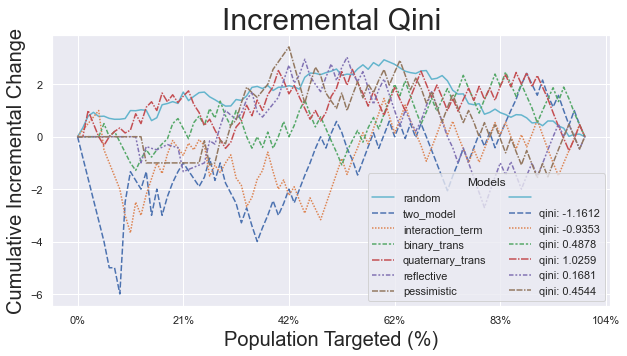

In [46]:
plot_qini(
    df=df_visual_eval,
    n=100,
    models=models,
    percent_of_pop=True,
    outcome_col="y_test",
    treatment_col="w_test",
    normalize=False,
    random_seed=42,
    figsize=None,
    fontsize=20,
    axis=None,
    legend_metrics=True,
)
# plt.savefig("./mayo_qini.png", dpi=150)

## Iterated Evaluation and Variance

In [49]:
# Qini
df_model_eval = eval_table(model_eval_dict, variances=True, annotate_vars=True)

df_model_eval

,TwoModel,InteractionTerm,BinaryTransformation,QuaternaryTransformation,ReflectiveUplift,PessimisticUplift
Mayo PBC,-0.3195 ± 0.3527,-0.37 ± 0.5117,0.6445 ± 0.4083,0.728 ± 0.395,-0.1751 ± 0.2558,-0.0531 ± 0.2586
